In [1]:
import pandas as pd
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = ['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness','insulin', 'bmi', 
                'diabetes_pedigree', 'age', 'outcome']
df = pd.read_csv(url, names=column_names)

SEED = 44713
df_sample = df.sample(n=500, random_state=SEED)
display(df_sample.head())
print(df_sample.shape)

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree,age,outcome
565,2,95,54,14,88,26.1,0.748,22,0
204,6,103,72,32,190,37.7,0.324,55,0
163,2,100,64,23,0,29.7,0.368,21,0
726,1,116,78,29,180,36.1,0.496,25,0
155,7,152,88,44,0,50.0,0.337,36,1


(500, 9)


**Preprocesamiento**

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np


cols_zero_as_missing = ['glucose','blood_pressure','skin_thickness','insulin','bmi']

X = df_sample.drop(columns=['outcome']).copy()
y = df_sample['outcome'].astype(int).copy()

X[cols_zero_as_missing] = X[cols_zero_as_missing].replace(0, np.nan)

preprocess = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

Modelos

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
models = {
    "LogReg": Pipeline([
        ("prep", preprocess),
        ("clf", LogisticRegression(max_iter=2000, solver="lbfgs"))
        #("clf", LogisticRegression(max_iter=2000, solver="lbfgs", class_weight="balanced"))
    ]),
    "KNN": Pipeline([
        ("prep", preprocess),
        ("clf", KNeighborsClassifier(n_neighbors=5))
    ]),
    "LDA": Pipeline([
        ("prep", preprocess),
        ("clf", LinearDiscriminantAnalysis())
    ]),
    "QDA": Pipeline([
        ("prep", preprocess),
        ("clf", QuadraticDiscriminantAnalysis(reg_param=1e-3))  # leve regularización por estabilidad
    ]),
    "GNB": Pipeline([
        ("prep", preprocess),
        ("clf", GaussianNB())
    ]),
}

10-fold Cross-validation 

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
}

rows, fold_scores = [], {}
for name, pipe in models.items():
    cvres = cross_validate(pipe, X, y, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1)
    fold_scores[name] = cvres
    rows.append({
        "model": name,
        "accuracy_mean":  cvres["test_accuracy"].mean(),
        "accuracy_std":   cvres["test_accuracy"].std(ddof=1),
        "precision_mean": cvres["test_precision"].mean(),
        "recall_mean":    cvres["test_recall"].mean(),
        "f1_mean":        cvres["test_f1"].mean(),
    })

df_scores = pd.DataFrame(rows).sort_values("f1_mean", ascending=False).reset_index(drop=True)
df_scores

,model,accuracy_mean,accuracy_std,precision_mean,recall_mean,f1_mean
0,GNB,0.756,0.036271,0.700511,0.638889,0.661538
1,LogReg,0.754,0.049933,0.715264,0.596491,0.645567
2,LDA,0.758,0.043665,0.726315,0.585965,0.643848
3,QDA,0.744,0.032387,0.693450,0.596491,0.634292
4,KNN,0.706,0.063979,0.629699,0.559357,0.587415


**Matriz de Confusion**

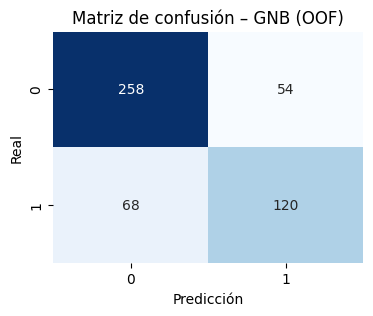

== Reporte de clasificación (OOF) – GNB ==
              precision    recall  f1-score   support

           0     0.7914    0.8269    0.8088       312
           1     0.6897    0.6383    0.6630       188

    accuracy                         0.7560       500
   macro avg     0.7405    0.7326    0.7359       500
weighted avg     0.7532    0.7560    0.7540       500



In [11]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
# Seleccionamos el mejor modelo: GNB
best_model = models["GNB"]

# Predicciones OOF (out-of-fold)
y_pred_oof = cross_val_predict(best_model, X, y, cv=cv, n_jobs=-1)

# Matriz de confusión
cm = confusion_matrix(y, y_pred_oof)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión – GNB (OOF)")
plt.show()

# Reporte de clasificación
print("== Reporte de clasificación (OOF) – GNB ==")
print(classification_report(y, y_pred_oof, digits=4))